### Global Carbon Budget

Plot and manipulate GCB2023, building to a version useful in Humans and the Carbon Cycle, Fall 2024 (EESC 4020)

August 7 2024 Version

In [1]:
%run plots.ipynb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import openpyxl # <- needed to open xlsx
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget 
# ^ allows zooming in to the plots!

import cmocean as cm    

import gcsfs
fs = gcsfs.GCSFileSystem()

### Load data from GCB Excel

In [3]:
# Data from the Global Carbon Budget, HistoricalBudget page 
# from file Global_Carbon_Budget_2023v1.0.xlsx at https://essd.copernicus.org/articles/15/5301/2023/

GCB23historical = pd.read_excel('/home/jovyan/galen_course/Global_Carbon_Budget_2023v1.1.xlsx',sheet_name='Historical Budget',skiprows=15,nrows=273)

### extract 1850 forward; stack plot as in Figure 3 of GCB

Use historical file since the timeseries are already connected between the pre-modern and modern estimates

In [4]:
GCB23historical1850 = GCB23historical[GCB23historical['Year'].between(1850,2023)]

In [5]:
GCB23historical1850

,Year,fossil emissions excluding carbonation,land-use change emissions,atmospheric growth,ocean sink,land sink,cement carbonation sink,budget imbalance
100,1850,0.053699,0.721410,0.189248,0.164195,0.458676,NaN,-0.037010
101,1851,0.054222,0.745880,0.125528,0.165485,0.015269,NaN,0.493819
102,1852,0.056609,0.758793,0.069667,0.171645,0.127952,NaN,0.446138
103,1853,0.059258,0.774983,0.009770,0.172905,0.177041,NaN,0.474525
104,1854,0.069605,0.784710,-0.039082,0.174320,0.452846,NaN,0.266231
...,...,...,...,...,...,...,...,...
268,2018,10.034647,1.169527,5.076360,2.907491,3.604710,0.198196,-0.582584
269,2019,10.109199,1.254780,5.310000,2.955932,3.009866,0.201583,-0.113403
270,2020,9.554514,1.172267,4.970160,2.914365,3.110044,0.206858,-0.474646
271,2021,10.048183,1.179470,5.203800,2.825585,3.542677,0.216463,-0.560872


### Stacked plot has emissions (positive) and sinks (negative). Sinks include atmosphere. Each source / sink is progressively added. 

This is a closed system, so the sum of sources should equal the sum of sinks. The black dash line mirrors the total emissions. 
If we knew the budgets perfectly, the dash black would fall on the atmosphere exactly. The lack of concurrence is our inability to close the budget


In [6]:
# getting total time range
time = GCB23historical1850['Year']

# calculating emissions
fossil_fuels = GCB23historical1850['fossil emissions excluding carbonation']
land_use = GCB23historical1850['land-use change emissions']

total_emissions = fossil_fuels + land_use

# calculating sinks: made negative to emphasize that they are SINKS!
ocean_sink = -GCB23historical1850['ocean sink']
land_sink = -GCB23historical1850['land sink']
atmo_sink = -GCB23historical1850['atmospheric growth']

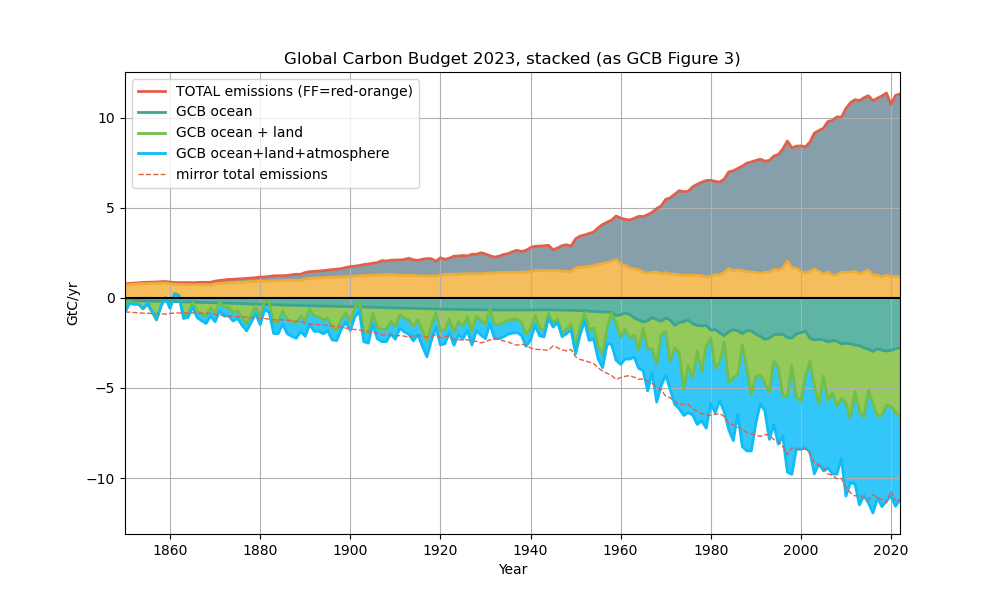

In [7]:
fig = GCB_plot(time, total_emissions,land_use,ocean_sink,land_sink,oceanfactor=1,landfactor=1)

## Add a factor to ocean or land sink and see what would have happened to atmosphere if this sink had been smaller

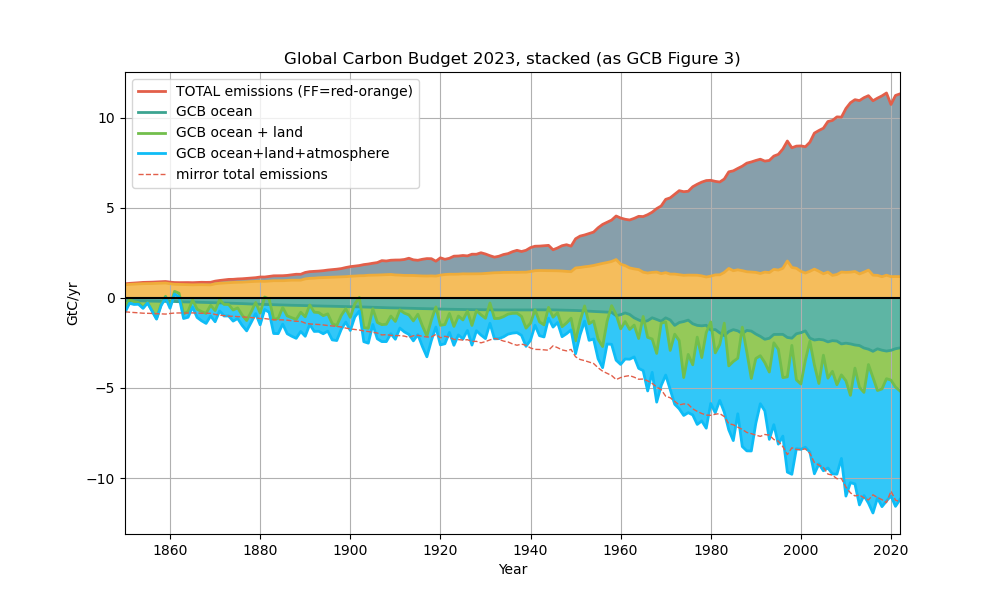

In [8]:
fig = GCB_plot(time, total_emissions,land_use,ocean_sink,land_sink,oceanfactor=0.5,landfactor=1)

## Direct comparison between ocean factor changes

Text(0.5, 1.0, 'Global Carbon Budget 2023, stacked. Ocean reduced from observed.')

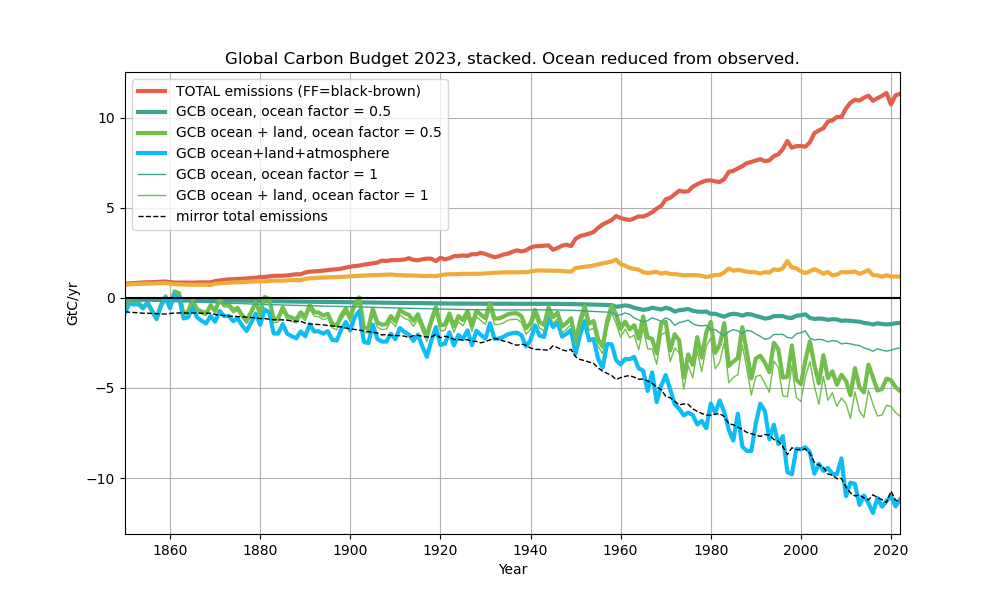

In [9]:
oceanfactor=0.5
landfactor=1

ocean_land = oceanfactor*ocean_sink + landfactor*land_sink
ocean_land_atmo = oceanfactor*ocean_sink + landfactor*land_sink + atmo_sink + (1-oceanfactor)*ocean_sink
mirror_total_emissions = -total_emissions

fig = plt.figure(figsize=(10,6))
plt.plot(time,total_emissions,'#e25f4a',label = "TOTAL emissions (FF=black-brown)",linewidth=3)
plt.plot(time,land_use,'#efac39',linewidth=3)

# MODIFIED
plt.plot(time,oceanfactor*ocean_sink,'#3ca490',label = f"GCB ocean, ocean factor = {oceanfactor}",linewidth=3)
plt.plot(time,oceanfactor*ocean_sink+land_sink,'#72be4c',label = f"GCB ocean + land, ocean factor = {oceanfactor}",linewidth=3)
plt.plot(time,ocean_land_atmo,'#0ebcf6',label = "GCB ocean+land+atmosphere",linewidth=3)

oceanfactor=1
ocean_land = oceanfactor*ocean_sink + landfactor*land_sink
ocean_land_atmo = oceanfactor*ocean_sink + landfactor*land_sink + atmo_sink + (1-oceanfactor)*ocean_sink
mirror_total_emissions = -total_emissions

# ORIGINAL
plt.plot(time,ocean_sink,'#3ca490',linewidth=1, label='GCB ocean, ocean factor = 1')
plt.plot(time,ocean_land,'#72be4c',linewidth=1,label='GCB ocean + land, ocean factor = 1')
plt.plot(time,ocean_land_atmo,'#0ebcf6',linewidth=1)

plt.plot(time,mirror_total_emissions,'black',linestyle='dashed',label = "mirror total emissions",linewidth=1)

plt.grid(True)
plt.legend(frameon = True)
plt.ylabel('GtC/yr')
plt.xlabel('Year')
plt.axhline(0,c='black')
plt.xlim(1850,2022)
plt.title('Global Carbon Budget 2023, stacked. Ocean reduced from observed.')
# plt.ylim(-12,0)

## Sum the atmosphere from 1959 onward and compare to Mauna Loa CO2 observations 

Then will apply factor for "what if ocean were stronger or weaker" and can see impact to atmosphere

In [10]:
# data source for CO2 mole fraction (ppm) measured monthly at Mauna Loa since 1958
# https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv

# The atmosphere is rapidly mixed by the winds, so this timeseries is a good proxy for the global mean atmospheric pCO2
xCO2atm_ML = pd.read_csv('/home/jovyan/galen_course/co2_mm_mlo.csv', skiprows=40,nrows=796) 

### Since the mauna loa starts in mid-1958, we restrict the data to starting 1959

In [11]:
# select only 1959 forward
GCB23historical1959 = GCB23historical[GCB23historical['Year'].between(1959,2023)]

### integrate the growth rate in GtC/yr to give GtC, then divide by conversion to get ppm; then add 1958 value in ppm

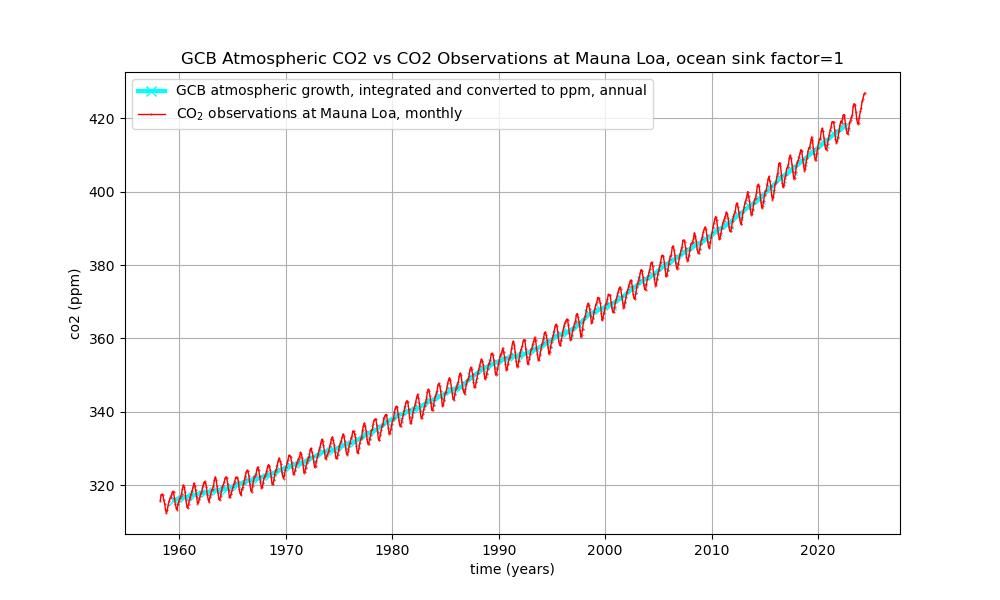

In [12]:
atmospheric_co2_plot(GCB23historical1959, xCO2atm_ML)

This first plot establishes that the Mauna Loa data and our integrated growth rate are (approximately) the same

### now apply ocean factor and compare again to see "what if the ocean sink had been stronger or weaker?"

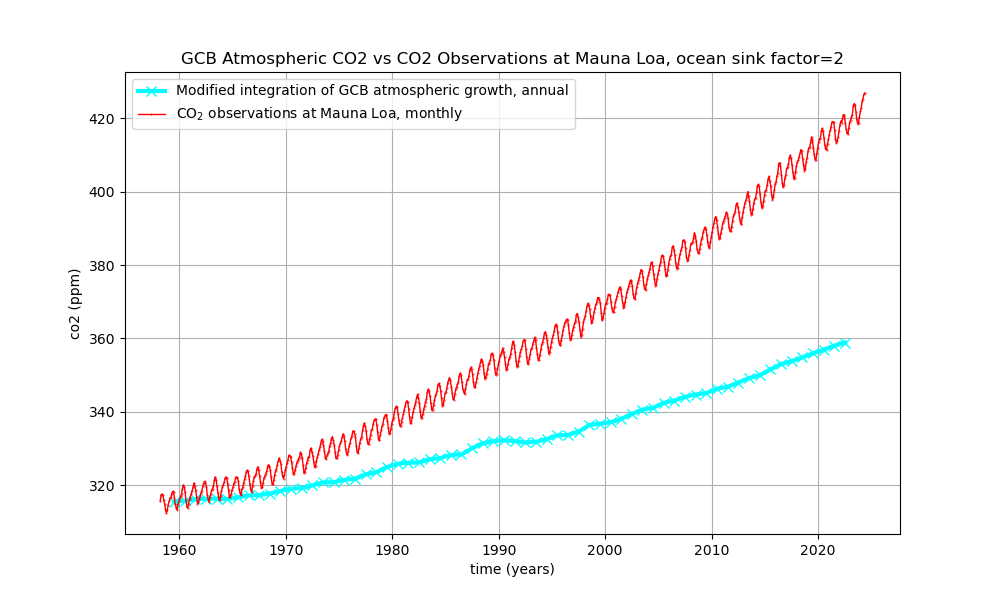

In [13]:
atmospheric_co2_plot(GCB23historical1959, xCO2atm_ML, oceanfactor=2)

If the ocean could take up twice as much carbon, we would have much less of a global warming problem!

Conversely, if the ocean were only half as efficient, we would have much more of a problem

## bar plot comparing emissions to sinks

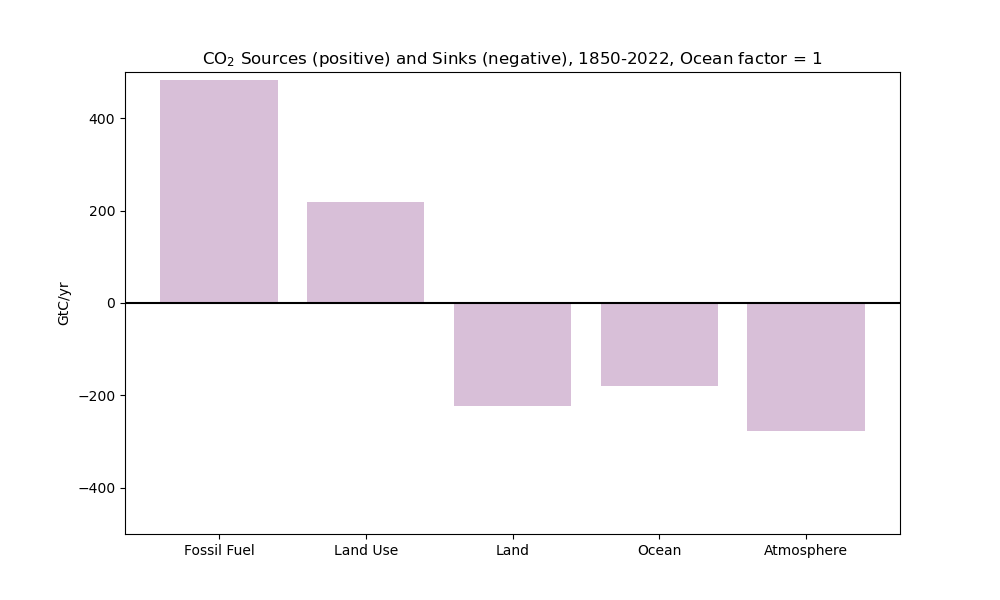

In [14]:
bar_plot(fossil_fuels,land_use,land_sink,ocean_sink,atmo_sink,oceanfactor=1)
# bar_plot(fossil_fuels,land_use,land_sink,ocean_sink,atmo_sink,oceanfactor=2)